In [1]:
%pip install -q "openvino>=2023.3.0" "nncf>=2.8.1" "opencv-python" "seaborn" "matplotlib" "pandas" "scikit-learn" "torch" "torchvision" "gradio"  --extra-index-url https://download.pytorch.org/whl/cpu

Note: you may need to restart the kernel to use updated packages.


In [2]:
import sys
from pathlib import Path
sys.path.append("../utils")
from notebook_utils import download_file

if not Path('yolov9').exists():
    !git clone https://github.com/WongKinYiu/yolov9
%cd yolov9

/home/ea/work/openvino_notebooks/notebooks/287-yolov9-optimization/yolov9


In [3]:
# Download pre-trained model weights
MODEL_LINK = "https://github.com/WongKinYiu/yolov9/releases/download/v0.1/gelan-c.pt"
DATA_DIR = Path("data/")
MODEL_DIR = Path("model/")
MODEL_DIR.mkdir(exist_ok=True)
DATA_DIR.mkdir(exist_ok=True)

download_file(MODEL_LINK, directory=MODEL_DIR, show_progress=True)

'model/gelan-c.pt' already exists.


PosixPath('/home/ea/work/openvino_notebooks/notebooks/287-yolov9-optimization/yolov9/model/gelan-c.pt')

In [4]:
from models.experimental import attempt_load
import torch
import openvino as ov
from models.yolo import Detect, DualDDetect

weights = MODEL_DIR / "gelan-c.pt"
model = attempt_load(weights, device="cpu", inplace=True, fuse=True)

model.eval()
for k, m in model.named_modules():
    if isinstance(m, (Detect, DualDDetect)):
        m.inplace = False
        m.dynamic = True
        m.export = True


example_input = torch.zeros((1, 3, 640, 640))
metadata = {'stride': int(max(model.stride)), 'names': model.names}
model(example_input)

ov_model = ov.convert_model(model, example_input=example_input)

Fusing layers... 
Model summary: 467 layers, 25472640 parameters, 0 gradients, 102.8 GFLOPs
/home/ea/work/openvino_notebooks/notebooks/287-yolov9-optimization/yolov9/models/yolo.py:108: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  elif self.dynamic or self.shape != shape:


In [5]:
ov_model.outputs[0].get_tensor().set_names({"output0"})
ov_model.inputs[0].get_tensor().set_names({"images"})

ov.save_model(ov_model, MODEL_DIR / "gelan-c_openvino_model/gelan-c.xml")

In [6]:
from utils.general import yaml_save

yaml_save(MODEL_DIR / "gelan-c_openvino_model/gelan-c.yaml", metadata) 

In [7]:
import numpy as np
import torch
from PIL import Image
from utils.augmentations import letterbox


def preprocess_image(img0: np.ndarray):
    """
    Preprocess image according to YOLOv7 input requirements. 
    Takes image in np.array format, resizes it to specific size using letterbox resize, converts color space from BGR (default in OpenCV) to RGB and changes data layout from HWC to CHW.
    
    Parameters:
      img0 (np.ndarray): image for preprocessing
    Returns:
      img (np.ndarray): image after preprocessing
      img0 (np.ndarray): original image
    """
    # resize
    img = letterbox(img0, auto=False)[0]
    
    # Convert
    img = img.transpose(2, 0, 1)
    img = np.ascontiguousarray(img)
    return img, img0


def prepare_input_tensor(image: np.ndarray):
    """
    Converts preprocessed image to tensor format according to YOLOv7 input requirements. 
    Takes image in np.array format with unit8 data in [0, 255] range and converts it to torch.Tensor object with float data in [0, 1] range
    
    Parameters:
      image (np.ndarray): image for conversion to tensor
    Returns:
      input_tensor (torch.Tensor): float tensor ready to use for YOLOv7 inference
    """
    input_tensor = image.astype(np.float32)  # uint8 to fp16/32
    input_tensor /= 255.0  # 0 - 255 to 0.0 - 1.0
    
    if input_tensor.ndim == 3:
        input_tensor = np.expand_dims(input_tensor, 0)
    return input_tensor


# label names for visualization
DEFAULT_NAMES = ['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light',
                 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
                 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee',
                 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard',
                 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
                 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch',
                 'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
                 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear',
                 'hair drier', 'toothbrush']

NAMES = model.names

In [8]:
from utils.plots import Annotator, colors

from typing import List, Tuple
from utils.general import scale_boxes, non_max_suppression


def detect(model: ov.Model, image_path: Path, conf_thres: float = 0.25, iou_thres: float = 0.45, classes: List[int] = None, agnostic_nms: bool = False):
    """
    OpenVINO YOLOv7 model inference function. Reads image, preprocess it, runs model inference and postprocess results using NMS.
    Parameters:
        model (Model): OpenVINO compiled model.
        image_path (Path): input image path.
        conf_thres (float, *optional*, 0.25): minimal accpeted confidence for object filtering
        iou_thres (float, *optional*, 0.45): minimal overlap score for remloving objects duplicates in NMS
        classes (List[int], *optional*, None): labels for prediction filtering, if not provided all predicted labels will be used
        agnostic_nms (bool, *optiona*, False): apply class agnostinc NMS approach or not
    Returns:
       pred (List): list of detections with (n,6) shape, where n - number of detected boxes in format [x1, y1, x2, y2, score, label] 
       orig_img (np.ndarray): image before preprocessing, can be used for results visualization
       inpjut_shape (Tuple[int]): shape of model input tensor, can be used for output rescaling
    """
    output_blob = model.output(0)
    if isinstance(image_path, np.ndarray):
        img = image_path
    else:
        img = np.array(Image.open(image_path))
    preprocessed_img, orig_img = preprocess_image(img)
    input_tensor = prepare_input_tensor(preprocessed_img)
    predictions = torch.from_numpy(model(input_tensor)[output_blob])
    pred = non_max_suppression(predictions, conf_thres, iou_thres, classes=classes, agnostic=agnostic_nms)
    return pred, orig_img, input_tensor.shape


def draw_boxes(predictions: np.ndarray, input_shape: Tuple[int], image: np.ndarray, names: List[str]):
    """
    Utility function for drawing predicted bounding boxes on image
    Parameters:
        predictions (np.ndarray): list of detections with (n,6) shape, where n - number of detected boxes in format [x1, y1, x2, y2, score, label]
        image (np.ndarray): image for boxes visualization
        names (List[str]): list of names for each class in dataset
        colors (Dict[str, int]): mapping between class name and drawing color
    Returns:
        image (np.ndarray): box visualization result
    """
    if not len(predictions):
        return image

    annotator = Annotator(image, line_width=3, example=str(names))
    # Rescale boxes from input size to original image size
    predictions[:, :4] = scale_boxes(input_shape[2:], predictions[:, :4], image.shape).round()

    # Write results
    for *xyxy, conf, cls in reversed(predictions):
        label = f'{names[int(cls)]} {conf:.2f}'
        annotator.box_label(xyxy, label, color=colors(int(cls), True))
    return image

In [9]:
core = ov.Core()
# read converted model
model = core.read_model('model/gelan-c_openvino_model/gelan-c.xml')

In [10]:
import ipywidgets as widgets

device = widgets.Dropdown(
    options=core.available_devices + ["AUTO"],
    value='AUTO',
    description='Device:',
    disabled=False,
)

device

Dropdown(description='Device:', index=3, options=('CPU', 'GPU.0', 'GPU.1', 'AUTO'), value='AUTO')

In [11]:
# load model on CPU device
compiled_model = core.compile_model(model, device.value)

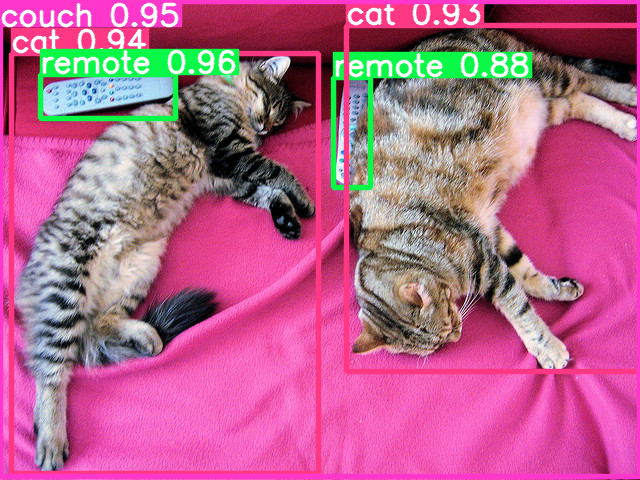

In [12]:
boxes, image, input_shape = detect(compiled_model, '../000000039769.jpg')
image_with_boxes = draw_boxes(boxes[0], input_shape, image, NAMES)
# visualize results
Image.fromarray(image_with_boxes)

In [13]:
from zipfile import ZipFile

sys.path.append("../../utils")
from notebook_utils import download_file

DATA_URL = "http://images.cocodataset.org/zips/val2017.zip"
LABELS_URL = "https://github.com/ultralytics/yolov5/releases/download/v1.0/coco2017labels-segments.zip"

OUT_DIR = Path('.')

download_file(DATA_URL, directory=OUT_DIR, show_progress=True)
download_file(LABELS_URL, directory=OUT_DIR, show_progress=True)

if not (OUT_DIR / "coco/labels").exists():
    with ZipFile('coco2017labels-segments.zip' , "r") as zip_ref:
        zip_ref.extractall(OUT_DIR)
    with ZipFile('val2017.zip' , "r") as zip_ref:
        zip_ref.extractall(OUT_DIR / 'coco/images')

'val2017.zip' already exists.
'coco2017labels-segments.zip' already exists.


In [14]:
from collections import namedtuple
import yaml
from utils.dataloaders import create_dataloader
from utils.general import colorstr

# read dataset config
DATA_CONFIG = 'data/coco.yaml'
with open(DATA_CONFIG) as f:
    data = yaml.load(f, Loader=yaml.SafeLoader)

# Dataloader
TASK = 'val'  # path to train/val/test images
Option = namedtuple('Options', ['single_cls'])  # imitation of commandline provided options for single class evaluation
opt = Option(False)
dataloader = create_dataloader(
    str(Path("coco") /  data[TASK]), 640, 1, 32, opt, pad=0.5,
    prefix=colorstr(f'{TASK}: ')
)[0]

val: Scanning coco/val2017.cache... 4952 images, 48 backgrounds, 0 corrupt: 100%|██████████| 5000/5000 00:00


In [15]:
import nncf  # noqa: F811


def transform_fn(data_item):
    """
    Quantization transform function. Extracts and preprocess input data from dataloader item for quantization.
    Parameters:
       data_item: Tuple with data item produced by DataLoader during iteration
    Returns:
        input_tensor: Input data for quantization
    """
    img = data_item[0].numpy()
    input_tensor = prepare_input_tensor(img) 
    return input_tensor


quantization_dataset = nncf.Dataset(dataloader, transform_fn)

INFO:nncf:NNCF initialized successfully. Supported frameworks detected: torch, tensorflow, onnx, openvino


In [16]:
quantized_model = nncf.quantize(model, quantization_dataset, preset=nncf.QuantizationPreset.MIXED)

ov.save_model(quantized_model, 'model/gelan-c_int8_openvino_model/gelan-c_int8.xml')

2024-02-27 20:08:21.811447: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-27 20:08:21.813490: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-27 20:08:21.847835: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-27 20:08:22.557188: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Output()

Output()

In [17]:
compiled_model = core.compile_model(quantized_model, device.value)

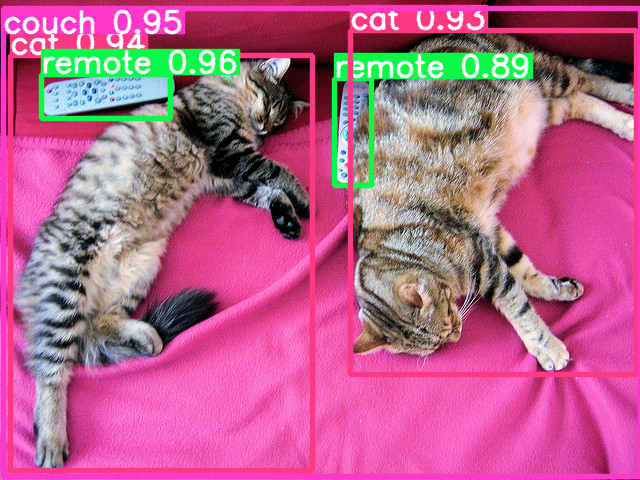

In [18]:
boxes, image, input_shape = detect(compiled_model, '../000000039769.jpg')
image_with_boxes = draw_boxes(boxes[0], input_shape, image, NAMES)
# visualize results
Image.fromarray(image_with_boxes)

In [19]:
!benchmark_app -m "model/gelan-c_int8_openvino_model/gelan-c_int8.xml" -shape "[1,3,640,640]" -d $device.value -api async -t 15

[Step 1/11] Parsing and validating input arguments
[ INFO ] Parsing input parameters
[Step 2/11] Loading OpenVINO Runtime
[ WARNING ] Default duration 120 seconds is used for unknown device AUTO
[ INFO ] OpenVINO:
[ INFO ] Build ................................. 2023.3.0-13775-ceeafaf64f3-releases/2023/3
[ INFO ] 
[ INFO ] Device info:
[ INFO ] AUTO
[ INFO ] Build ................................. 2023.3.0-13775-ceeafaf64f3-releases/2023/3
[ INFO ] 
[ INFO ] 
[Step 3/11] Setting device configuration
[ WARNING ] Performance hint was not explicitly specified in command line. Device(AUTO) performance hint will be set to PerformanceMode.THROUGHPUT.
[Step 4/11] Reading model files
[ INFO ] Loading model files
[ INFO ] Read model took 77.90 ms
[ INFO ] Original model I/O parameters:
[ INFO ] Model inputs:
[ INFO ]     x (node: x) : f32 / [...] / [?,3,?,?]
[ INFO ] Model outputs:
[ INFO ]     output0 (node: __module.model.22/aten::cat/Concat_5) : f32 / [...] / [?,84,8400]
[ INFO ]     85 , 20

In [20]:
!benchmark_app -m "model/gelan-c_openvino_model/gelan-c.xml" -shape "[1,3,640,640]" -d $device.value -api async -t 15

[Step 1/11] Parsing and validating input arguments
[ INFO ] Parsing input parameters
[Step 2/11] Loading OpenVINO Runtime
[ WARNING ] Default duration 120 seconds is used for unknown device AUTO
[ INFO ] OpenVINO:
[ INFO ] Build ................................. 2023.3.0-13775-ceeafaf64f3-releases/2023/3
[ INFO ] 
[ INFO ] Device info:
[ INFO ] AUTO
[ INFO ] Build ................................. 2023.3.0-13775-ceeafaf64f3-releases/2023/3
[ INFO ] 
[ INFO ] 
[Step 3/11] Setting device configuration
[ WARNING ] Performance hint was not explicitly specified in command line. Device(AUTO) performance hint will be set to PerformanceMode.THROUGHPUT.
[Step 4/11] Reading model files
[ INFO ] Loading model files
[ INFO ] Read model took 35.37 ms
[ INFO ] Original model I/O parameters:
[ INFO ] Model inputs:
[ INFO ]     x (node: x) : f32 / [...] / [?,3,?,?]
[ INFO ] Model outputs:
[ INFO ]     output0 (node: __module.model.22/aten::cat/Concat_5) : f32 / [...] / [?,84,8400]
[ INFO ]     2038 , 

In [21]:
import collections
import time
from IPython import display
from notebook_utils import VideoPlayer
import cv2


# Main processing function to run object detection.
def run_object_detection(source=0, flip=False, use_popup=False, skip_first_frames=0, model=ov_model, device=device.value):
    player = None
    compiled_model = core.compile_model(model, device)
    try:
        # Create a video player to play with target fps.
        player = VideoPlayer(
            source=source, flip=flip, fps=30, skip_first_frames=skip_first_frames
        )
        # Start capturing.
        player.start()
        if use_popup:
            title = "Press ESC to Exit"
            cv2.namedWindow(
                winname=title, flags=cv2.WINDOW_GUI_NORMAL | cv2.WINDOW_AUTOSIZE
            )

        processing_times = collections.deque()
        while True:
            # Grab the frame.
            frame = player.next()
            if frame is None:
                print("Source ended")
                break
            # If the frame is larger than full HD, reduce size to improve the performance.
            scale = 1280 / max(frame.shape)
            if scale < 1:
                frame = cv2.resize(
                    src=frame,
                    dsize=None,
                    fx=scale,
                    fy=scale,
                    interpolation=cv2.INTER_AREA,
                )
            # Get the results.
            input_image = np.array(frame)
           
            start_time = time.time()
            # model expects RGB image, while video capturing in BGR
            detections, _, input_shape = detect(compiled_model, input_image[:, :, ::-1])
            stop_time = time.time()
            
            image_with_boxes = draw_boxes(detections[0], input_shape, input_image, NAMES)
            frame = image_with_boxes
           
            processing_times.append(stop_time - start_time)
            # Use processing times from last 200 frames.
            if len(processing_times) > 200:
                processing_times.popleft()

            _, f_width = frame.shape[:2]
            # Mean processing time [ms].
            processing_time = np.mean(processing_times) * 1000
            fps = 1000 / processing_time
            cv2.putText(
                img=frame,
                text=f"Inference time: {processing_time:.1f}ms ({fps:.1f} FPS)",
                org=(20, 40),
                fontFace=cv2.FONT_HERSHEY_COMPLEX,
                fontScale=f_width / 1000,
                color=(0, 0, 255),
                thickness=1,
                lineType=cv2.LINE_AA,
            )
            # Use this workaround if there is flickering.
            if use_popup:
                cv2.imshow(winname=title, mat=frame)
                key = cv2.waitKey(1)
                # escape = 27
                if key == 27:
                    break
            else:
                # Encode numpy array to jpg.
                _, encoded_img = cv2.imencode(
                    ext=".jpg", img=frame, params=[cv2.IMWRITE_JPEG_QUALITY, 100]
                )
                # Create an IPython image.
                i = display.Image(data=encoded_img)
                # Display the image in this notebook.
                display.clear_output(wait=True)
                display.display(i)
    # ctrl-c
    except KeyboardInterrupt:
        print("Interrupted")
    # any different error
    except RuntimeError as e:
        print(e)
    finally:
        if player is not None:
            # Stop capturing.
            player.stop()
        if use_popup:
            cv2.destroyAllWindows()

In [22]:
WEBCAM_INFERENCE = False

if WEBCAM_INFERENCE:
    VIDEO_SOURCE = 0  # Webcam
else:
    VIDEO_SOURCE = 'https://storage.openvinotoolkit.org/repositories/openvino_notebooks/data/data/video/people.mp4'

In [23]:
device

Dropdown(description='Device:', index=3, options=('CPU', 'GPU.0', 'GPU.1', 'AUTO'), value='AUTO')

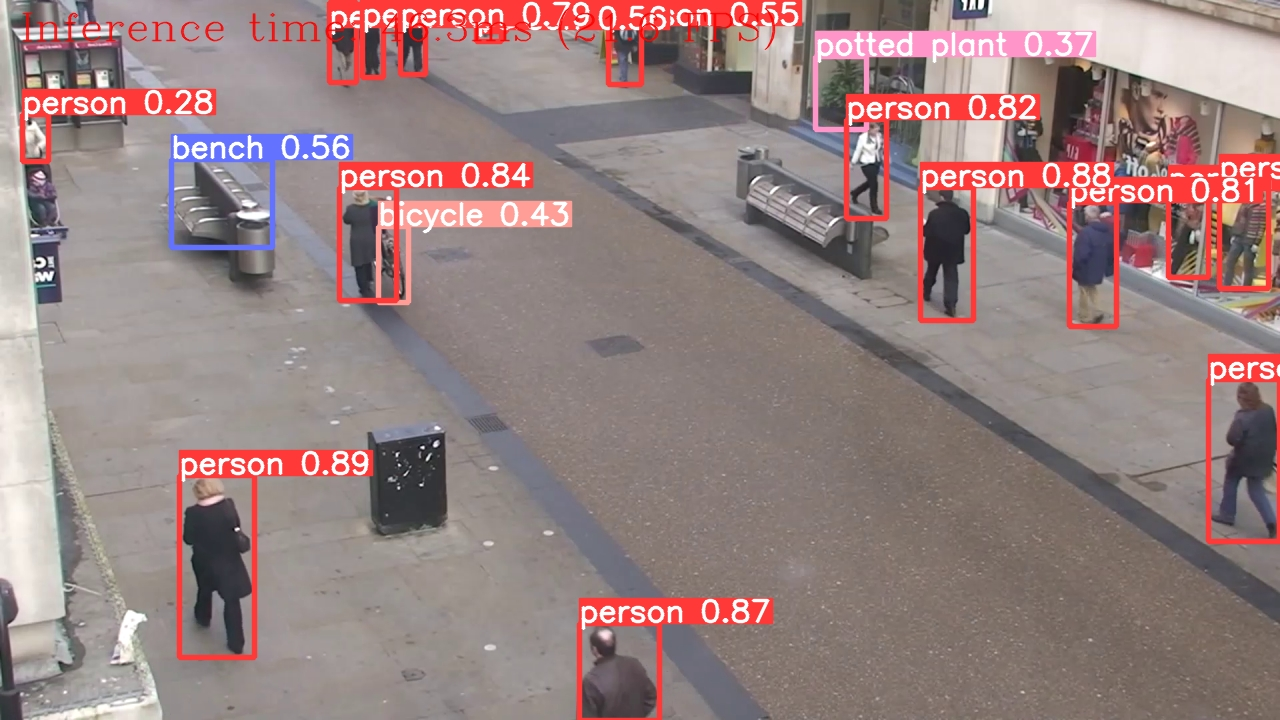

Source ended


In [24]:
run_object_detection(source=VIDEO_SOURCE, flip=True, use_popup=False, model=quantized_model, device=device.value)